In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv("A3 Experimental Data - Sheet1.csv")
df = df.iloc[:, :-1]

df_filtered = df[(df['Id'] != '1zspd') & ((df['GuessValue'] != 50) | (df['Error'] != 0))]  # removed '1zspd' due to them being an extreme outlier for time considerations
df_filtered = df_filtered[df_filtered.groupby('Id')['Id'].transform('count') >= 50]

df_filtered.head()

,Id,Date,Type,TrueValue,GuessValue,Error,Point1,Point2
25,9tcrn,2/11/2024 13:27:55,Bar,11.363636,10,0.57,5,44
26,9tcrn,2/11/2024 13:28:04,Bar,41.666667,50,3.08,30,72
27,9tcrn,2/11/2024 13:28:14,Bar,87.096774,90,1.60,54,62
28,9tcrn,2/11/2024 13:28:34,Bar,30.526316,20,3.41,29,95
29,9tcrn,2/11/2024 13:28:59,Radar,40.000000,33,2.83,38,95


In [9]:
print(df["Type"].value_counts())
print(df_filtered["Type"].value_counts())

Radar    249
Pie      248
Bar      242
Name: Type, dtype: int64
Radar    218
Pie      218
Bar      217
Name: Type, dtype: int64


In [80]:
from tabulate import tabulate

print(df.groupby("Type")["Error"].agg(["mean", "std"]))
print(tabulate(df_filtered.groupby("Type")["Error"].agg(["mean", "std"]), headers="keys", tablefmt="pretty"))

df = df_filtered

           mean       std
Type                     
Bar    1.654909  1.819077
Pie    2.010769  1.858394
Radar  2.673363  1.859343
+-------+--------------------+--------------------+
| Type  |        mean        |        std         |
+-------+--------------------+--------------------+
|  Bar  | 1.6549090909090909 | 1.8190773643391924 |
|  Pie  | 2.0107692307692306 | 1.858394430722354  |
| Radar | 2.6733632286995515 | 1.8593430710223693 |
+-------+--------------------+--------------------+


In [81]:
pie = df[df['Type'] == 'Pie']['Error']
radar = df[df['Type'] == 'Radar']['Error']
bar = df[df['Type'] == 'Bar']['Error']
pie.head()

58    1.43
59    2.81
60    2.54
61   -2.16
62    3.14
Name: Error, dtype: float64

In [82]:
from scipy.stats import sem
from sklearn.utils import resample


def bootstrap_confidence_interval(data, n_bootstrap, alpha):
    bootstrap_errors = []
    for Vis in range(n_bootstrap):
        sample = resample(data)
        error_mean = sample.mean()
        bootstrap_errors.append(error_mean)

    mean_error = np.mean(bootstrap_errors)
    lower_bound = np.percentile(bootstrap_errors, (1-alpha)/2 * 100)
    upper_bound = np.percentile(bootstrap_errors, (1+alpha)/2 * 100)
    return lower_bound, mean_error, upper_bound

n_bootstrap = 1000
alpha = 0.05

pie_ci = bootstrap_confidence_interval(pie, n_bootstrap, alpha)
radar_ci = bootstrap_confidence_interval(radar, n_bootstrap, alpha)
bar_ci = bootstrap_confidence_interval(bar, n_bootstrap, alpha)

print("Bootstrap Lower, Mean, and Upper Bound for Pie Error:", pie_ci)
print("Bootstrap Lower, Mean, and Upper Bound for Radar Error:", radar_ci)
print("Bootstrap Lower, Mean, and Upper Bound for Bar Error:", bar_ci)

Bootstrap Lower, Mean, and Upper Bound for Pie Error: (2.0081097285067875, 2.01313185520362, 2.024940045248869)
Bootstrap Lower, Mean, and Upper Bound for Radar Error: (2.6694428251121076, 2.6729277130044844, 2.68154932735426)
Bootstrap Lower, Mean, and Upper Bound for Bar Error: (1.6536863636363635, 1.662924, 1.6715909090909091)


# Confidence Interval Visualization

<ipython-input-83-093303bd4a46>:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(mean, y, 'ro', color='black')


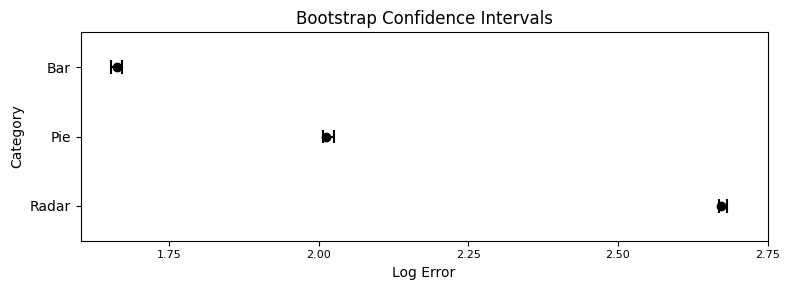

In [83]:
import pandas as pd
from matplotlib import pyplot as plt

data_dict = {}
data_dict['category'] = ['Bar', 'Pie', 'Radar']
data_dict['lower'] = [[bar_ci[0]],[pie_ci[0]], [radar_ci[0]]]
data_dict['mean'] = [[bar_ci[1]],[pie_ci[1]],[radar_ci[1]]]
data_dict['upper'] = [[bar_ci[2]], [pie_ci[2]],[radar_ci[2]]]
dataset = pd.DataFrame(data_dict)


category_order = ['Radar', 'Pie', 'Bar']
dataset['category'] = pd.Categorical(dataset['category'], categories=category_order, ordered=True)
dataset = dataset.sort_values(by='category')

plt.figure(figsize=(8, 3))

for lower, mean, upper, y, label in zip(dataset['lower'], dataset['mean'], dataset['upper'], range(len(dataset)), dataset['category']):
    plt.vlines(lower, y - 0.1, y + 0.1, colors='black', linestyles='solid')
    plt.vlines(upper, y - 0.1, y + 0.1, colors='black', linestyles='solid')
    plt.plot(mean, y, 'ro', color='black')
    plt.hlines(y, lower, upper, colors='black', linestyles='solid')

plt.yticks(range(len(dataset)), list(dataset['category']))
plt.xlabel('Log Error')
plt.ylabel('Category')
plt.title('Bootstrap Confidence Intervals')
plt.ylim(-0.5, len(dataset) - 0.5)
plt.xticks(fontsize=8)

ticks = [1.75, 2.0, 2.25, 2.5, 2.75]
plt.xticks(ticks)

# plt.grid(True)
plt.tight_layout()
plt.show()

# Time

In [92]:

df = pd.read_csv("A3 Experimental Data - Sheet1.csv")
df = df.iloc[: , :-1]

df_filtered = df[(df['Id'] != '1zspd')]# removed '1zspd' due to them being an extreme outlier for time considerations
df_filtered = df_filtered[df_filtered.groupby('Id')['Id'].transform('count') >= 50]
df=df_filtered


df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Id', 'Date'])
df['TimePerGuess'] = df.groupby('Id')['Date'].diff().dt.total_seconds()
df.dropna(subset=['TimePerGuess'], inplace=True)

# Time for each guess relative to the previous guess

print(df.head(20))

print(df.groupby('Type')['TimePerGuess'].mean())

        Id                Date   Type  TrueValue  GuessValue  Error  Point1  \
287  1harg 2024-02-11 22:37:44    Bar  14.925373           5   3.33      10   
288  1harg 2024-02-11 22:37:57    Bar  89.743590          25   6.02      35   
289  1harg 2024-02-11 22:38:38  Radar  86.904762          80   2.81      73   
290  1harg 2024-02-11 22:38:47    Bar  60.526316          50   3.41      46   
291  1harg 2024-02-11 22:39:06  Radar  95.121951          30   6.03      39   
292  1harg 2024-02-11 22:39:16    Pie  10.606061           9   0.79       7   
293  1harg 2024-02-11 22:39:25    Pie   8.045977           5   1.66       7   
294  1harg 2024-02-11 22:39:32    Bar   6.410256           2   2.18       5   
295  1harg 2024-02-11 22:39:37    Pie  18.367347          18  -1.02       9   
296  1harg 2024-02-11 22:39:43    Bar   4.411765           2   1.34       3   
297  1harg 2024-02-11 22:39:48    Bar   9.090909           2   2.85       2   
298  1harg 2024-02-11 22:39:54    Pie   3.947368    

In [85]:
pieT = df[df['Type'] == 'Pie']['TimePerGuess']
radarT = df[df['Type'] == 'Radar']['TimePerGuess']
barT = df[df['Type'] == 'Bar']['TimePerGuess']

pie_ci = bootstrap_confidence_interval(pieT, n_bootstrap, alpha)
radar_ci = bootstrap_confidence_interval(radarT, n_bootstrap, alpha)
bar_ci = bootstrap_confidence_interval(barT, n_bootstrap, alpha)

print("Bootstrap Lower, Mean, and Upper Bound for Pie Time:", pie_ci)
print("Bootstrap Lower, Mean, and Upper Bound for Radar Time:", radar_ci)
print("Bootstrap Lower, Mean, and Upper Bound for Bar Time:", bar_ci)

Bootstrap Lower, Mean, and Upper Bound for Pie Time: (21.128440366972477, 21.59434862385321, 21.424197247706424)
Bootstrap Lower, Mean, and Upper Bound for Radar Time: (14.48165137614679, 14.553128440366972, 14.55045871559633)
Bootstrap Lower, Mean, and Upper Bound for Bar Time: (13.317972350230415, 13.373594470046084, 13.40552995391705)


<ipython-input-86-de2042122b24>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(mean, y, 'ro', color='black')


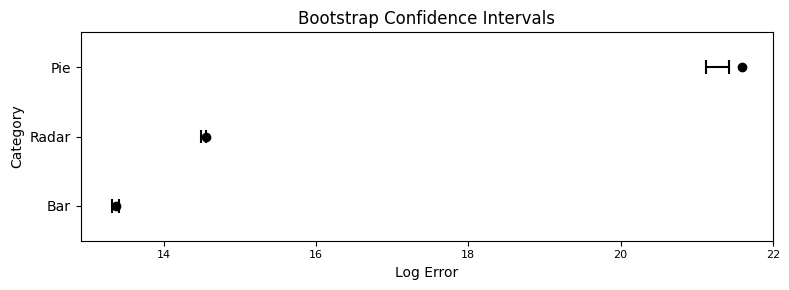

In [86]:
data_dict = {}
data_dict['category'] = ['Bar', 'Pie', 'Radar']
data_dict['lower'] = [[bar_ci[0]],[pie_ci[0]], [radar_ci[0]]]
data_dict['mean'] = [[bar_ci[1]],[pie_ci[1]],[radar_ci[1]]]
data_dict['upper'] = [[bar_ci[2]], [pie_ci[2]],[radar_ci[2]]]
dataset = pd.DataFrame(data_dict)


category_order = ['Bar', 'Radar', 'Pie']
dataset['category'] = pd.Categorical(dataset['category'], categories=category_order, ordered=True)
dataset = dataset.sort_values(by='category')

plt.figure(figsize=(8, 3))

for lower, mean, upper, y, label in zip(dataset['lower'], dataset['mean'], dataset['upper'], range(len(dataset)), dataset['category']):
    plt.vlines(lower, y - 0.1, y + 0.1, colors='black', linestyles='solid')
    plt.vlines(upper, y - 0.1, y + 0.1, colors='black', linestyles='solid')
#     plt.text(lower - 0.03, y + 0.05, f"{lower:.2f}", color='orange', fontsize=8)
#     plt.text(upper - 0.03, y + 0.05, f"{upper:.2f}", color='orange', fontsize=8)
    plt.plot(mean, y, 'ro', color='black')
#     plt.text(mean - 0.03, y - 0.1, f"{mean:.2f}", color='green', fontsize=8)
    plt.hlines(y, lower, upper, colors='black', linestyles='solid')

plt.yticks(range(len(dataset)), list(dataset['category']))
plt.xlabel('Log Error')
plt.ylabel('Category')
plt.title('Bootstrap Confidence Intervals')
plt.ylim(-0.5, len(dataset) - 0.5)
plt.xticks(fontsize=8)

# plt.grid(True)
plt.tight_layout()
plt.show()

# Outliers

In [74]:




Q1 = df['TimePerGuess'].quantile(0.05)
Q3 = df['TimePerGuess'].quantile(0.95)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = df[(df['TimePerGuess'] < lower_bound) | (df['TimePerGuess'] > upper_bound)]

print("Outliers:")
print(outliers)

Outliers:
        Id                Date   Type  TrueValue  GuessValue  Error  Point1  \
562  5gzdh 2024-02-12 17:28:24  Radar  63.829787          40   4.58      30   
576  5gzdh 2024-02-12 17:32:11    Pie  54.347826          70   3.98      25   
550  70xns 2024-02-12 16:22:32    Bar   3.174603           5   0.96       2   
115  aizcu 2024-02-11 14:32:58  Radar  16.666667          16  -0.34      12   
438  oh1ka 2024-02-12 15:16:28    Pie  30.000000           3   4.76      18   

     Point2  TimePerGuess  
562      47         117.0  
576      46          75.0  
550      63          76.0  
115      72          81.0  
438      60        1449.0  


In [76]:
df = pd.read_csv("A3 Experimental Data - Sheet1.csv")
df = df.iloc[: , :-1]

id = "1zspd"
filtered_df = df[df['Id'] == id]

# Print the filtered DataFrame
print(filtered_df)

        Id                Date   Type  TrueValue  GuessValue  Error  Point1  \
5    1zspd  2/11/2024 13:18:51    Bar  74.418605          50   0.00      32   
6    1zspd  2/11/2024 13:19:06    Bar  74.418605          28   5.54      32   
7    1zspd  2/11/2024 13:19:22    Pie  61.363636          10   5.69      27   
8    1zspd  2/11/2024 13:19:34    Bar  92.000000           5   6.45      69   
9    1zspd  2/11/2024 13:19:46  Radar  92.553191           5   6.45      87   
..     ...                 ...    ...        ...         ...    ...     ...   
410  1zspd  2/12/2024 14:04:10    Pie  27.027027          25   1.11      10   
423  1zspd  2/12/2024 14:05:59  Radar  79.545455          98   4.22      35   
430  1zspd  2/12/2024 14:06:39    Bar  54.545455          55  -0.79      42   
432  1zspd  2/12/2024 14:06:48    Pie  18.918919          34   3.93      14   
434  1zspd  2/12/2024 14:07:00    Pie  61.111111          50   3.49      11   

     Point2  
5        43  
6        43  
7        